In [ ]:
# 구글 드라이브와 연동하는 방법 입니다. 
# Google File Drive Stream 접근을 허용해야 합니다.
from google.colab import auth
auth.authenticate_user()

# 구글 드라이브 mount 
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
%cd gdrive/My Drive/datasets/DCGAN

/content/gdrive/My Drive/datasets/DCGAN


In [ ]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam,SGD
from keras import initializers
import os
import keras
from keras import layers
import matplotlib.pyplot as plt
import sys
import numpy as np
from keras.preprocessing import image

Using TensorFlow backend.


In [ ]:
(X_train, y_train), (_, _) = keras.datasets.cifar10.load_data()
X_train = X_train[y_train.flatten() == 3]

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
# figure를 plt로 visualize
def visualize_rgb(img):
    """
    Visualize a rgb image
    :param img: RGB image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Image")
    plt.show()

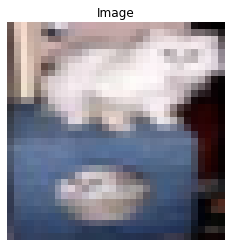

In [ ]:
visualize_rgb(X_train[6])

In [ ]:
# Input shape
img_rows = 32
img_cols = 32
channels = 3
        
img_shape = (img_rows, img_cols, channels)        
latent_dim = 100

In [ ]:
# latent space dimension
latent_dim = 100

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# FC: 2x2x512
# input (100,) --> Output 2*2*512, 
generator.add(Dense(2*2*512, input_shape=(latent_dim,), activation='relu', kernel_initializer=init))
generator.add(Reshape((2, 2, 512)))

# # Conv 1: (2,2,512) --> (4,4,256)
generator.add(UpSampling2D())
generator.add(Conv2D(256, kernel_size=3, activation='relu', kernel_initializer=init, use_bias=False, strides=1, padding='same'))
generator.add(BatchNormalization())

# Conv 2: (4,4,256) --> (8,8,128)
generator.add(UpSampling2D())
generator.add(Conv2D(128, kernel_size=3, activation='relu',use_bias=False, kernel_initializer=init, strides=1, padding='same'))
generator.add(BatchNormalization())


# Conv 3: (8,8,128) --> (16,16,64)
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=3, activation='relu', use_bias=False, kernel_initializer=init, strides=1, padding='same'))
generator.add(BatchNormalization())

# Conv 4: (16,16,64) --> (32,32,3)
generator.add(UpSampling2D())
generator.add(Conv2D(3, kernel_size=3, strides=1, padding='same',kernel_initializer=init, activation='tanh'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 256)         1179648   
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)        

In [ ]:
# imagem shape 32x32x3
# x_batch = (4, 32, 32, 3)
# x_batch[0]  --> (32, 32, 3)
img_shape = X_train[0].shape
# img_shape <-- (32, 32, 3)

# Discriminator network
discriminator = Sequential()

# Conv 1: (32, 32, 3)  --> (15,15,64)
discriminator.add(Conv2D(64, kernel_size=3, strides=2, use_bias=False, padding='valid',
                         input_shape=(img_shape), kernel_initializer=init))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))


# Conv 2: (15,15, 64) --> (7, 7, 128)
discriminator.add(Conv2D(128, kernel_size=3, strides=2,  kernel_initializer=init, use_bias=False, padding='valid'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 3: (7, 7, 128) --> (3,3, 256)
discriminator.add(Conv2D(256, kernel_size=3, strides=2, kernel_initializer=init, use_bias=False, padding='valid'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# (3,3, 256) --> (256)
discriminator.add(GlobalAveragePooling2D())

# Output
discriminator.add(Dense(1, activation='sigmoid'))

In [ ]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 15, 15, 64)        1728      
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 15, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)         73728     
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 3, 3, 256)        

In [ ]:
# Optimizer
discriminator.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# d_g = discriminador(generador(z))
discriminator.trainable = False

z = Input(shape=(latent_dim,))
fake = generator(z)
decision = discriminator(fake)
gan_model = Model(inputs=z, outputs=decision)

gan_model.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

In [ ]:
# 0 ~ 255 -127.5 --> -127.5 ~ 127,5 / 127.5
# -1 ~ 1
def normalize(img):
  img = ((img / 255.0) * 2.0) - 1.0 
  return img

In [ ]:
def denormalize(img):
  img = ((img + 1) * 0.5) * 255.0
  return np.clip(img, a_min=0, a_max=255)

In [ ]:
print(X_train.shape)

(5000, 32, 32, 3)


In [ ]:
# 데이터를 정규화합니다
X_train = normalize(X_train)

iterations = 5000
batch_size = 32
save_dir = os.path.join("./", 'gan_images')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [ ]:
epochs = 5000
batch_size = 32
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch, y=real)

        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
        # Discriminator loss
        d_loss_batch = (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        g_loss_batch = gan_model.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 30 == 0:
      gan_model.save_weights('gan.h5')

      img = image.array_to_img(denormalize(X_fake[0]), scale=False)
      img.save(os.path.join(save_dir, 'generated' + str(e) + '.png'))

      img = image.array_to_img(denormalize(X_batch[0]), scale=False)
      img.save(os.path.join(save_dir, 'real' + str(e) + '.png'))
       


epoch = 1/5000, d_loss=1.140, g_loss=0.761                                                                                                     
epoch = 2/5000, d_loss=1.306, g_loss=0.752                                                                                                     
epoch = 3/5000, d_loss=1.338, g_loss=0.726                                                                                                     
epoch = 4/5000, d_loss=1.289, g_loss=0.768                                                                                                     
epoch = 5/5000, d_loss=1.312, g_loss=0.772                                                                                                     
epoch = 6/5000, d_loss=1.376, g_loss=0.734                                                                                                     
epoch = 7/5000, d_loss=1.358, g_loss=0.765                                                                                             